Paquetes

In [ ]:
import torch
import numpy as np
from torch import nn
import torchvision
from collections import OrderedDict
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import utils

# Definicion de modelo

In [ ]:
class VGG(nn.Module):
    """
    Standard PyTorch implementation of VGG. Pretrained imagenet model is used.
    """
    def __init__(self):
        super().__init__()
    
        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),
            
            # conv2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv5
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 1000)
        )

        # We need these for MaxUnpool operation
        self.conv_layer_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()

Cargar pesos

In [15]:
vgg = VGG()
temp = torchvision.models.vgg16(pretrained=True)
vgg.load_state_dict(temp.state_dict())

c:\Users\Pablo\miniconda3\envs\joint\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pablo\miniconda3\envs\joint\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

Testeo

In [16]:
def visualizar_imagen(imagen):
    imagen = imagen.numpy()
    imagen = imagen/imagen.max()
    imagen = np.clip(imagen, 0, 1)
    return Image.fromarray(np.uint8(imagen*255))

Imagen de prueba

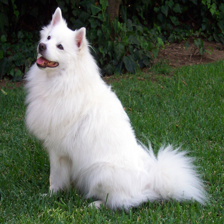

In [17]:
input_image = Image.open("dog.jpg")
input_image.resize((224, 224))

Transformaciones imagen -> tensor

In [18]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    vgg.to('cuda')

## Vista interna del modelo

Para visualizar los filtros:

In [20]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        img = grid.numpy().transpose((1, 2, 0))
        width = 200
        height = img.shape[0] * width // img.shape[1]

        Image.fromarray(np.uint8(img*255)).resize((width,height), resample=Image.Resampling.NEAREST).save("filtros.png")

In [21]:
x = input_batch

with torch.no_grad():
    for layer in vgg.features:
        if isinstance(layer, nn.MaxPool2d):
            x, location = layer(x)
        else:
            x = layer(x)
        
        # Visualizar las convoluciones
        if isinstance(layer, nn.Conv2d):
            filtro = layer.weight.data.clone().cpu()
            visTensor(filtro, ch=0, allkernels=False)

        vis = x[0].cpu()
        images = [visualizar_imagen(i) for i in vis]
        
        i = 0
        for i, image in enumerate(images):
            i += 1
            if i > 10:
                break
            image.save('feature_maps/output_{}.jpg'.format(i))

        print("")
    
    x = x.view(x.size()[0], -1)
    x = vgg.classifier(x)
    output = x

# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
probabilities = torch.nn.functional.softmax(output[0], dim=0)


C:\Users\Pablo\AppData\Local\Temp\ipykernel_10588\57610459.py:3: RuntimeWarning: invalid value encountered in divide
  imagen = imagen/imagen.max()


C:\Users\Pablo\AppData\Local\Temp\ipykernel_10588\57610459.py:3: RuntimeWarning: invalid value encountered in divide
  imagen = imagen/imagen.max()


C:\Users\Pablo\AppData\Local\Temp\ipykernel_10588\57610459.py:3: RuntimeWarning: invalid value encountered in divide
  imagen = imagen/imagen.max()


C:\Users\Pablo\AppData\Local\Temp\ipykernel_10588\57610459.py:3: RuntimeWarning: invalid value encountered in divide
  imagen = imagen/imagen.max()


C:\Users\Pablo\AppData\Local\Temp\ipykernel_10588\57610459.py:3: RuntimeWarning: invalid value encountered in divide
  imagen = imagen/imagen.max()


C:\Users\Pablo\AppData\Local\Temp\ipykernel_10588\57610459.py:3: RuntimeWarning: invalid value encountered in divide
  imagen = imagen/imagen.max()



tensor([-4.0505e+00, -2.1677e+00, -2.7900e+00, -4.6294e+00, -4.9664e+00,
        -3.6707e+00, -4.7726e+00,  1.9706e+00,  5.6080e+00, -2.3081e+00,
        -3.7653e+00, -1.9897e+00, -4.8115e+00, -1.8978e+00, -2.1880e+00,
        -2.4090e+00, -1.1976e+00, -3.0770e-01,  1.3475e+00, -2.9646e+00,
        -2.3596e+00, -3.4581e+00, -1.5709e+00,  2.6021e+00, -3.0363e+00,
        -3.2313e+00, -4.2067e+00, -2.0306e+00, -3.3107e+00, -6.0411e-01,
        -4.9605e+00, -3.3572e+00, -4.2165e+00, -4.5677e+00, -3.8407e+00,
        -4.5351e+00, -3.0273e+00, -3.2312e+00, -6.0044e+00, -3.6425e+00,
        -2.6192e+00, -4.0658e+00, -5.2530e+00, -4.6340e+00, -5.6470e+00,
        -2.6358e+00, -6.7267e-01, -5.6912e+00, -3.8389e+00, -3.7286e+00,
        -2.5835e+00, -4.3183e+00, -1.8430e+00, -4.8322e+00, -3.3930e+00,
        -2.9939e+00, -3.7655e+00, -3.5557e+00, -3.5083e+00, -3.1867e+00,
        -1.4796e+00, -5.3809e+00, -4.9246e+00, -2.9185e+00, -3.4360e+00,
        -5.7439e+00, -5.0981e+00, -4.2328e+00, -5.

# Categorias

In [14]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())


Samoyed 0.8911295533180237
Eskimo dog 0.037249598652124405
white wolf 0.01586417853832245
Siberian husky 0.014435823075473309
Arctic fox 0.010683962143957615
